In this notebook, we will explore some strategies for filtering the output of a generative model. 

### 0. Setup
To install
<pre>pip install posebusters rdkit pandas useful_rdkit_utils mols2grid seaborn rdkit tqdm</pre>

In [1]:
from posebusters import PoseBusters
from rdkit import Chem
from rdkit.Chem import PandasTools
import useful_rdkit_utils as uru
import mols2grid
from rdkit.Chem.Draw import MolsToGridImage
import pandas as pd
import seaborn as sns
import itertools 
from rdkit.Chem import rdMolAlign
from operator import itemgetter
from tqdm.auto import tqdm
from rdkit.Chem import AllChem

Enable Pandas **progress_apply**

In [2]:
tqdm.pandas()

Read the DiffLinker output.  The SDF was created by converting from **xyz** with OEChem. 

In [3]:
df_0 = PandasTools.LoadSDF("all.sdf")

[09:43:59] Explicit valence for atom # 23 C, 5, is greater than permitted
[09:43:59] ERROR: Could not sanitize molecule ending on line 27080
[09:43:59] ERROR: Explicit valence for atom # 23 C, 5, is greater than permitted


### 1. Remove Failed Entries
Some of the output structures failed to connect the fragments.  We can use the **count_fragments** function from [useful_rdkit_uitls](https://useful-rdkit-utils.readthedocs.io/en/latest/) to identify these molecules. 

In [4]:
df_0['num_frags'] = df_0.ROMol.apply(uru.count_fragments)

How many molecules have multiple fragments?  

In [5]:
df_0.num_frags.value_counts()

num_frags
1    953
2     45
3      1
Name: count, dtype: int64

Remove molecules with more that 1 fragment. 

In [6]:
df_1 = df_0.query("num_frags == 1").copy()

### 2. Find and Remove Duplicate Solutions
There are some duplicates in the DiffLinker ouput, we can use **InChI keys** to identify the duplicates. 

In [7]:
df_1['inchi'] = df_1.ROMol.apply(Chem.MolToInchiKey)

[09:44:00] unrecognized chirality tag (6) on atom 24 is ignored.


How many duplicates are there? 

In [8]:
df_1.inchi.value_counts()

inchi
NMNAZPLXJFFRRP-UHFFFAOYSA-N    145
XBWWHXRTLPSFET-UHFFFAOYSA-N     39
YTMHLJOIUUEKMH-UHFFFAOYSA-N     21
KYSSITKIFJXDGP-UHFFFAOYSA-N     20
XNQMJMXXRBNEIG-UHFFFAOYSA-N     15
                              ... 
GENYVSUUXAFRET-UHFFFAOYSA-O      1
POEFAKRUWXRMDD-UHFFFAOYSA-N      1
FBFOLWBEKQIIHJ-UHFFFAOYSA-N      1
HRWYDWCOHCSBIL-UHFFFAOYSA-N      1
DXUNVLDLWQMGQY-CYBMUJFWSA-N      1
Name: count, Length: 537, dtype: int64

Put all the structures with the most frequently occuring InChI key into a dataframe. 

In [9]:
df_freq = df_1.query("inchi == 'NMNAZPLXJFFRRP-UHFFFAOYSA-N'")

Calculate the distribution of RMS fits among the 145 copies of the most frequently occuring molecule. 

In [10]:
rms_list = []
for a,b in itertools.combinations(df_freq.ROMol,2):
    rms = AllChem.GetBestRMS(a,b)
    rms_list.append(rms)

Plot the RMS distribution

In [11]:
sns.set(rc={'figure.figsize': (5, 5)})
sns.set_style('whitegrid')
sns.set_context('talk')

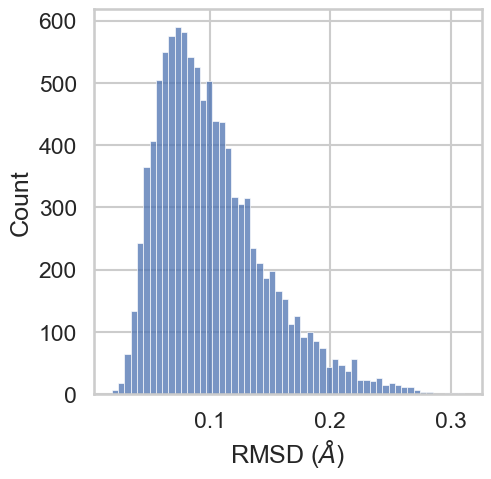

In [12]:
ax = sns.histplot(rms_list)
ax.set_xlabel("RMSD ($\AA$)");

Write the structures for the 145 copies of the most frequent molecule to disk.  I did this so I could visualize the results. 

In [13]:
PandasTools.WriteSDF(df_freq,"most_frequent.sdf")

Remove duplicate records

In [14]:
df_2 = df_1.drop_duplicates(subset="inchi").copy()

In [15]:
len(df_1),len(df_2)

(953, 537)

### 3. Find and Remove Molecules With Odd Ring Systems
The dataset contains some odd ring systems, we can use [useful_rdkit_uitls](https://useful-rdkit-utils.readthedocs.io/en/latest/) to identify these molecules.

In [16]:
ring_system_lookup = uru.RingSystemLookup.default()

For each molecule in **df_2**, identify the ring systems and their frequency in ChEMBL

In [17]:
df_2['ring_systems'] = [list(ring_system_lookup.process_mol(x)) for x in df_2.ROMol]

Find the ring system in each molecule that occurs with the lowest frequency in ChEMBL

In [18]:
df_2[['min_ring','min_freq']] = [list(uru.get_min_ring_frequency(x)) for x in df_2.ring_systems]

Look at the odd ring systems.  The number below each structure is the number of times that structure occurs in CheMBL. 

In [19]:
odd_ring_df = df_2.query("min_freq < 100").drop_duplicates(subset="min_ring").sort_values("min_freq")
mols2grid.display(odd_ring_df, smiles_col="min_ring", subset=["img"],     
                  custom_css=""".data-mols2grid-id-display { display: none }""",
                 selection=False)

MolGridWidget()

Remove molecules with a ring system occuring fewer than 100 times in ChEMBL

In [20]:
df_3 = df_2.query("min_freq >= 100").copy()

Look at how the filters pare down the dataset

In [21]:
len(df_0),len(df_1),len(df_2),len(df_3)

(999, 953, 537, 393)

### 4. Apply Functional Group Filters
Identify molecules containing objectionable functionality.  We'll use the **REOS** class in useful_rdkit_utils for this. 

In [22]:
reos = uru.REOS()

Do a quick survey of the number of molecules remaining after filtering with each of the rule sets

In [23]:
for rule_set in reos.get_available_rule_sets():
    reos.set_active_rule_sets([rule_set])
    if rule_set == "PW":
        reos.drop_rule("furans")
    reos_res = [reos.process_mol(x) for x in df_3.ROMol]
    reos_ok = [x for x in reos_res if x[0] == "ok"]
    print(rule_set, len(reos_ok))

Glaxo 354
Dundee 143
BMS 206
PAINS 385
SureChEMBL 309
MLSMR 223
Inpharmatica 314
LINT 300


Use the Dundee filters

In [24]:
reos.set_active_rule_sets(["Dundee"])

Run the REOS filtering

In [25]:
df_3[['rule_set','reos']] = [list(reos.process_mol(x)) for x in df_3.ROMol]

Look at the reasons for REOS failures

In [26]:
uru.value_counts_df(df_3,"reos")

,reos,count
0,ok,143
1,het-C-het not in ring,130
2,imine,42
3,Aliphatic long chain,19
4,acyclic C=C-O,17
5,isolated alkene,5
6,alkyl halide,5
7,Oxygen-nitrogen single bond,5
8,2-halo pyridine,4
9,aldehyde,3


Pull out six examples that failed because of the "het-C-het not in ring" (acetal, ketals, etc) rule.  Assign 2D coordinates to make the structures look better. 

In [27]:
mol_list = df_3.query("reos == 'het-C-het not in ring'").head(6).copy().ROMol.values
[AllChem.Compute2DCoords(x) for x in mol_list]

[0, 0, 0, 0, 0, 0]

- Get the SMARTS for the "het-C-het not in ring" rule. 
- Find matches for in the six molecules selected above. 
- Display the structures with the offending functionality highlighted.

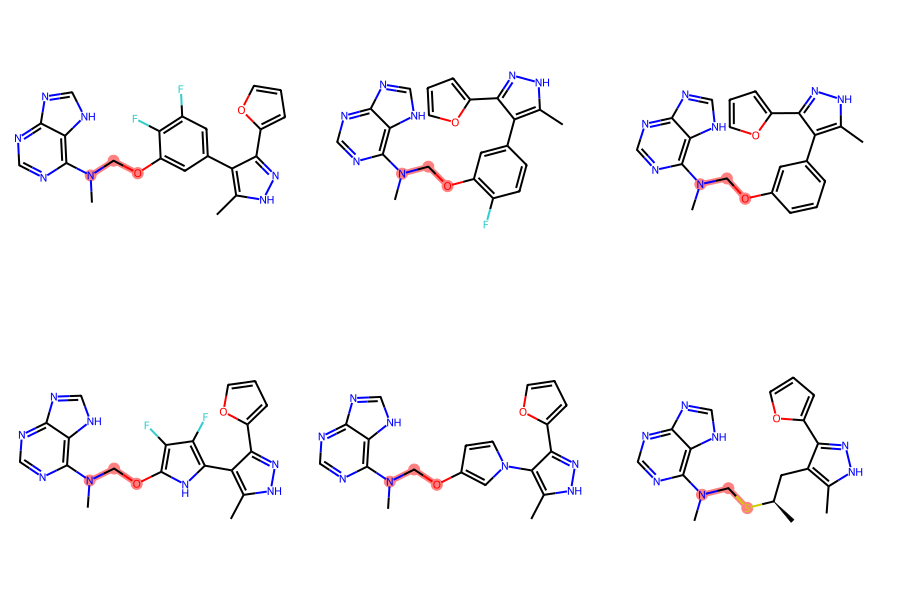

In [28]:
query_smarts = reos.active_rule_df.query("description == 'het-C-het not in ring'").smarts.values[0]
query_mol = Chem.MolFromSmarts(query_smarts)
match_atoms = [x.GetSubstructMatch(query_mol) for x in mol_list]
MolsToGridImage(mol_list,highlightAtomLists=match_atoms,subImgSize=(300, 300))

In [29]:
query_smarts

'[NX3R0,NX4R0,OR0,SX2R0][CX4][NX3R0,NX4R0,OR0,SX2R0]'

Select the molecules that passed the Dundee filters

In [30]:
df_4 = df_3.query("reos == 'ok'").copy()

Look at the remaining molecules 

In [31]:
mols2grid.display(df_4,mol_col="ROMol",size=(200,200))

MolGridWidget()

### 5. Filter Bad Geometries With PoseBusters
Instantiate a PoseBusters filter and run PoseBusters on the remaining molecules.

In [32]:
%%time
pb = PoseBusters(config="dock")
bust_df = pb.bust(df_4.ROMol,None,"3hz1_protein.pdb")

CPU times: user 7min 2s, sys: 1.47 s, total: 7min 3s
Wall time: 1min 5s


Look at the PoseBusters filters

In [33]:
bust_df.columns

Index(['mol_pred_loaded', 'mol_cond_loaded', 'sanitization',
       'all_atoms_connected', 'bond_lengths', 'bond_angles',
       'internal_steric_clash', 'aromatic_ring_flatness',
       'double_bond_flatness', 'internal_energy',
       'protein-ligand_maximum_distance', 'minimum_distance_to_protein',
       'minimum_distance_to_organic_cofactors',
       'minimum_distance_to_inorganic_cofactors', 'minimum_distance_to_waters',
       'volume_overlap_with_protein', 'volume_overlap_with_organic_cofactors',
       'volume_overlap_with_inorganic_cofactors',
       'volume_overlap_with_waters'],
      dtype='object')

Combine the PoseBusters output with **df_4**

In [34]:
cols = bust_df.columns
df_5 = pd.concat([df_4.reset_index(),bust_df.reset_index()[cols]],axis=1)

Get the sum of the PoseBusters scores

In [35]:
df_5['bust_sum'] = df_5[cols].sum(axis=1)

Look at distribution of PoseBusters sums

In [36]:
df_5.bust_sum.value_counts()

bust_sum
19    88
18    44
17    10
16     1
Name: count, dtype: int64

As a check write out the structure that only passes 16 PoseBusters filters.

In [37]:
m = df_5.query("bust_sum == 16").ROMol.values[0]
Chem.MolToMolFile(m,"buster.sdf")

Select the molecules that passed the PoseBusters filters

In [38]:
df_6 = df_5.query("bust_sum == 19").copy()

View the remaining molecules

In [39]:
mols2grid.display(df_6.sort_values("min_freq"),mol_col="ROMol",size=(200,200),subset=["img","min_freq"], selection=False)

MolGridWidget()

In [40]:
len(df_6)

88

### 6. Evaluate Conformer Strain
I wanted to do a quick check on the geometries of the DiffLinker structures.  To do this, I generated conformers for each molecule, fit each conformer to the DiffLinker structure, and calculated the RMSD. 

In [41]:
def gen_conformers(mol, num_confs=10):
    """Generate conformers for a molecule

    :param mol: RDKit molecule
    :return: molecule with conformers
    """
    try:
        mol = Chem.AddHs(mol)
        params = AllChem.ETKDGv3()
        params.useSmallRingTorsions = True
        AllChem.EmbedMultipleConfs(mol, numConfs=num_confs, params=params)
        AllChem.MMFFOptimizeMoleculeConfs(mol)
        mol = Chem.RemoveHs(mol)
    except ValueError:
        mol = None
    return mol

def compare_pose_with_conformers(ref_mol):
    conf_mol = Chem.MolFromSmiles(Chem.MolToSmiles(ref_mol))
    conf_mol = gen_conformers(conf_mol, num_confs=50)
    rmsd_list = []
    for i in range(0,conf_mol.GetNumConformers()):
        rmsd_list.append([rdMolAlign.GetBestRMS(conf_mol, ref_mol, refId=0, prbId=i),i])
    rmsd_list.sort(key=itemgetter(0))
    best_rmsd, best_pose_id = rmsd_list[0]
    best_pose_mol = Chem.Mol(conf_mol, confId=best_pose_id)
    return best_rmsd, best_pose_mol

Compare each structure in **df_6** with its conformers. 

In [42]:
df_6['near_conf'] = df_6.ROMol.progress_apply(compare_pose_with_conformers)

  0%|          | 0/88 [00:00<?, ?it/s]

Calculate the minimum conformer RMSD for each PoseBusters structure. 

In [43]:
df_6['min_rmsd'] = [x[0] for x in df_6.near_conf]

Display the RMSD.  Most are less that 1.5A so not too bad. 

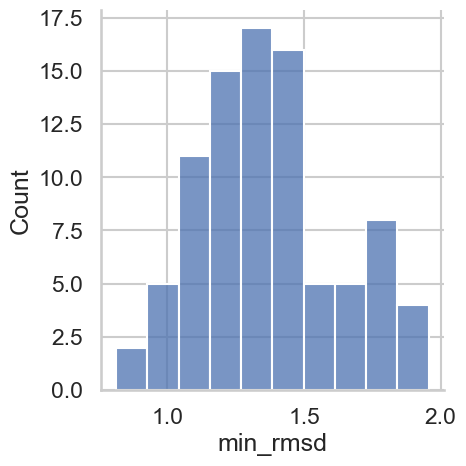

In [44]:
sns.displot(df_6.min_rmsd)

Write out some structures for the blog post figures

In [45]:
mol_34 = df_6.sort_values("min_freq").ROMol.values[34]
mol_34_rmsd, mol_34_min = compare_pose_with_conformers(mol_34)
Chem.MolToMolFile(mol_34_min,"mol_34_min.sdf")
Chem.MolToMolFile(df_6.sort_values("min_freq").ROMol.values[34],"mol_34.sdf")

In [46]:
Chem.MolToMolFile(df_6.sort_values("min_freq").ROMol.values[10],"mol_10.sdf")
mol_10 = df_6.sort_values("min_freq").ROMol.values[10]
mol_10_rmsd, mol_10_min = compare_pose_with_conformers(mol_10)
Chem.MolToMolFile(mol_10_min,"mol_10_min.sdf")